# 🎓 Lotka-Volterra Competition Model: Gold vs Bitcoin

**Bachelor Thesis - Frankfurt School**

Kevin Brot & Ivan Miraglia | November 2025

---

## 📋 Research Question

**Do Gold and Bitcoin compete for investor capital?**

Using Lotka-Volterra competition model from ecology adapted to finance.

---

## Notebook Overview

| Step | Task | Output |
|------|------|--------|
| 0 | Import libraries | Environment ready |
| 1 | Load data | 3 datasets |
| 2 | Interpolate & align | Time series |
| 3 | Normalize | Scaled data |
| 4 | Select alpha | Optimal smoothing |
| 5 | Train LV model | Coefficients |
| 6 | Significance tests | P-values |
| 7 | Predictions | Forecasts |
| 8 | Baselines | Comparison models |
| 9 | Evaluate | Final results |

## 📦 Step 0: Import Libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("="*80)
print(" IMPROVED LOTKA-VOLTERRA MODEL - ADDRESSING CRITICAL ISSUES")
print("="*80)

 IMPROVED LOTKA-VOLTERRA MODEL - ADDRESSING CRITICAL ISSUES


## ⚙️ INTERACTIVE CONFIGURATION

Run this cell and choose your settings!

In [29]:
# ============================================================================
# 🎮 INTERACTIVE SETTINGS - MODIFY THESE!
# ============================================================================

# ----- DATA FREQUENCY SELECTION -----
# Options: 'weekly' or 'monthly'
DATA_FREQUENCY = 'weekly'  # 👈 CHANGE THIS: 'weekly' or 'monthly'

# ----- REGIME SELECTION -----
# Choose which market regimes to include in your analysis
# Set to True to INCLUDE, False to EXCLUDE

REGIMES = {
    # Regime 1: Pre-COVID Bull Market (2016-2019)
    # - Stable growth period
    # - Low volatility
    # - Bitcoin adoption growing
    'pre_covid_bull': True,  # 👈 CHANGE: True or False
    
    # Regime 2: COVID Crisis & Recovery (2020-2021)
    # - Extreme volatility (March 2020 crash)
    # - Massive stimulus
    # - Bitcoin bull run to $60k
    # - Gold rally to $2000+
    'covid_era': True,  # 👈 CHANGE: True or False
    
    # Regime 3: Post-COVID Correction (2022-2023)
    # - Interest rate hikes
    # - Crypto winter (FTX collapse)
    # - Recession fears
    'post_covid_correction': True,  # 👈 CHANGE: True or False
    
    # Regime 4: Recent Period (2024-2025)
    # - Bitcoin ETF approval (Jan 2024)
    # - Bitcoin all-time highs
    # - Gold rally to $2700+
    'recent_period': True  # 👈 CHANGE: True or False
}

# ----- REGIME DATE DEFINITIONS -----
REGIME_DATES = {
    'pre_covid_bull': ('2016-01-01', '2019-12-31'),
    'covid_era': ('2020-01-01', '2021-12-31'),
    'post_covid_correction': ('2022-01-01', '2023-12-31'),
    'recent_period': ('2024-01-01', '2025-09-30')
}

# ----- MODEL PARAMETERS -----
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RIDGE_ALPHA = 0.01  # Regularization strength

# ----- FILE PATHS -----
PATH_GOLD_TONNES = r"C:\Users\Kevin\Downloads\Thesis\Data\Gold_AboveGround_Tonnes.xlsx"
PATH_LBMA_JSON = r"C:\Users\Kevin\Downloads\Thesis\Data\LBMA gold price 12.10.2025.json"
PATH_BTC_TSV = r"C:\Users\Kevin\Downloads\Thesis\Data\coin-metrics-new-chart.tsv.tsv"

# ----- OUTPUT DIRECTORY -----
OUTDIR = Path.cwd() / f"output_{DATA_FREQUENCY}"
OUTDIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# DISPLAY SELECTED CONFIGURATION
# ============================================================================

print("="*80)
print("🎮 INTERACTIVE LOTKA-VOLTERRA MODEL")
print("="*80)
print(f"\n📊 Data Frequency: {DATA_FREQUENCY.upper()}")
print(f"\n🎯 Selected Regimes:")
print("-"*80)

selected_regimes = []
regime_descriptions = {
    'pre_covid_bull': 'Pre-COVID Bull (2016-2019): Stable growth, low volatility',
    'covid_era': 'COVID Era (2020-2021): Crisis, stimulus, BTC to $60k',
    'post_covid_correction': 'Post-COVID (2022-2023): Rate hikes, crypto winter',
    'recent_period': 'Recent Period (2024-2025): BTC ETF, ATH, gold rally'
}

for regime, include in REGIMES.items():
    if include:
        print(f"  ✓ {regime_descriptions[regime]}")
        selected_regimes.append(regime)
    else:
        print(f"  ✗ {regime_descriptions[regime]} [EXCLUDED]")

if not selected_regimes:
    raise ValueError("⚠️ ERROR: You must select at least one regime!")

# Calculate date range
START_DATE = min([REGIME_DATES[r][0] for r in selected_regimes])
END_DATE = max([REGIME_DATES[r][1] for r in selected_regimes])

print(f"\n📅 Analysis Period: {START_DATE} to {END_DATE}")
print(f"\n⚙️ Model Settings:")
print(f"  - Train/Val/Test: {TRAIN_RATIO:.0%}/{VAL_RATIO:.0%}/{TEST_RATIO:.0%}")
print(f"  - Ridge Alpha: {RIDGE_ALPHA}")
print(f"\n💾 Output Directory: {OUTDIR}")
print("="*80)
print("\n✅ Configuration complete! Run the next cells to analyze.")

🎮 INTERACTIVE LOTKA-VOLTERRA MODEL

📊 Data Frequency: WEEKLY

🎯 Selected Regimes:
--------------------------------------------------------------------------------
  ✓ Pre-COVID Bull (2016-2019): Stable growth, low volatility
  ✓ COVID Era (2020-2021): Crisis, stimulus, BTC to $60k
  ✓ Post-COVID (2022-2023): Rate hikes, crypto winter
  ✓ Recent Period (2024-2025): BTC ETF, ATH, gold rally

📅 Analysis Period: 2016-01-01 to 2025-09-30

⚙️ Model Settings:
  - Train/Val/Test: 70%/15%/15%
  - Ridge Alpha: 0.01

💾 Output Directory: c:\Users\Kevin\Downloads\output_weekly

✅ Configuration complete! Run the next cells to analyze.


## 📂 Step 1: Load Data

## 📂 STEP 1: Load Raw Data

### Data Sources:

1. **Above-Ground Gold Stock (Annual)**
   - Source: World Gold Council / Metals Focus
   - Format: Excel file with yearly tonnes by category
   - **Total tonnes** = Jewellery + Central Banks + Private Investment + Bars & Coins + ETFs + Other

2. **LBMA Gold Price (Daily)**
   - Source: London Bullion Market Association
   - Converts tonnes → USD market value

3. **Bitcoin Market Cap (Daily)**
   - Source: Coin Metrics
   - Total network value

### Key Challenge:
Gold tonnes data is **annual**, needs interpolation to weekly/monthly.

In [30]:
print("\n" + "="*80)
print(" STEP 1: LOADING DATA")
print("="*80)

# [1A] ABOVE-GROUND GOLD STOCK (TONNES) - ANNUAL DATA
print("\n[1] Loading Above-Ground Gold Stock (Tonnes)...")
print("   NOTE: Annual data - will be interpolated")

gold_tonnes_raw = pd.read_excel(PATH_GOLD_TONNES, sheet_name=0)

year_col = gold_tonnes_raw.columns[0]
category_cols = gold_tonnes_raw.columns[1:]

print(f"   Categories: {list(category_cols)}")

# Sum all categories
gold_tonnes_raw['Total_Tonnes'] = gold_tonnes_raw[category_cols].sum(axis=1)

# Create date column (year-end: Dec 31)
gold_tonnes_raw['Date'] = pd.to_datetime(gold_tonnes_raw[year_col].astype(str) + '-12-31')

gold_tonnes = gold_tonnes_raw[['Date', 'Total_Tonnes']].copy()
gold_tonnes = gold_tonnes.dropna().sort_values('Date')

print(f"   ✓ Loaded {len(gold_tonnes)} annual observations")
print(f"   Years: {gold_tonnes['Date'].dt.year.min()}-{gold_tonnes['Date'].dt.year.max()}")
print(f"   Latest total: {gold_tonnes['Total_Tonnes'].iloc[-1]:,.0f} tonnes")

# [1B] LBMA GOLD PRICE
print("\n[2] Loading LBMA Gold Price...")
with open(PATH_LBMA_JSON, "r", encoding="utf-8") as f:
    lbma_data = json.load(f)

rows = [(rec.get("d"), rec.get("v", [])[0] if isinstance(rec.get("v", []), list) and len(rec.get("v", [])) > 0 else None) for rec in lbma_data]
lbma_df = pd.DataFrame(rows, columns=["Date", "Price_USD"])
lbma_df["Date"] = pd.to_datetime(lbma_df["Date"], errors="coerce")
lbma_df["Price_USD"] = pd.to_numeric(lbma_df["Price_USD"], errors="coerce")
lbma_df = lbma_df.dropna().sort_values("Date").drop_duplicates("Date")
print(f"   ✓ Loaded {len(lbma_df)} daily prices")

# [1C] BITCOIN MARKET CAP
print("\n[3] Loading Bitcoin Market Cap...")
encodings = ['utf-16', 'utf-16-le', 'utf-16-be', 'utf-8-sig', 'latin-1']
btc_df = None
for enc in encodings:
    try:
        btc_df = pd.read_csv(PATH_BTC_TSV, sep="\t", encoding=enc)
        break
    except (UnicodeDecodeError, UnicodeError):
        continue

if btc_df is None:
    raise ValueError("Could not read BTC TSV")

btc_df = btc_df[[btc_df.columns[0], btc_df.columns[2]]].copy()
btc_df.columns = ["Date", "MarketCap_USD"]
btc_df["Date"] = pd.to_datetime(btc_df["Date"], errors="coerce")
btc_df["MarketCap_USD"] = pd.to_numeric(btc_df["MarketCap_USD"], errors="coerce")
btc_df = btc_df.dropna().sort_values("Date")
print(f"   ✓ Loaded {len(btc_df)} daily observations")

print("\n✅ RAW DATA LOADED")


 STEP 1: LOADING DATA

[1] Loading Above-Ground Gold Stock (Tonnes)...
   NOTE: Annual data - will be interpolated
   Categories: ['Jewellery', 'Central_banks', 'Private_Investment', 'Bars_Coins', 'ETFs', 'Other', 'Total_Tonnes']
   ✓ Loaded 15 annual observations
   Years: 2010-2024
   Latest total: 529,798 tonnes

[2] Loading LBMA Gold Price...
   ✓ Loaded 14451 daily prices

[3] Loading Bitcoin Market Cap...
   ✓ Loaded 5578 daily observations

✅ RAW DATA LOADED


### 📊 Align to Selected Frequency & Filter Regimes


 STEP 2: INTERPOLATE GOLD TONNES & CALCULATE MARKET CAP

Target frequency: Weekly (Friday close)
Date range: 2016-01-01 to 2025-09-30

[Step 2A] Interpolating annual tonnes to daily frequency...
   ✓ Interpolated to 3561 daily observations
   Example: 2020-12-31 = 492,334 tonnes
   Example: 2021-06-30 = 496,856 tonnes (interpolated)
   Example: 2021-12-31 = 501,452 tonnes

[Step 2B] Converting tonnes to ounces and computing Gold market cap...
   ✓ Conversion factor: 32,150.75 oz/tonne
   ✓ Latest: 529,798 tonnes = 17,033,407,661 oz
   ✓ Gold market cap calculated for 3561 days
   ✓ Latest gold market cap: $65.16 Trillion

[Step 2C] Aligning BTC market cap and resampling to target frequency...
   ✓ Resampled to 509 weekly observations

[Step 2D] Building complete dataframe...
   ✓ Built df_all with 508 observations
   ✓ Full range: 2016-01-08 → 2025-09-26

[Step 2E] Filtering to selected regimes...
  • pre_covid_bull: 208 observations (2016-01-01 to 2019-12-31)
  • covid_era: 105 obser

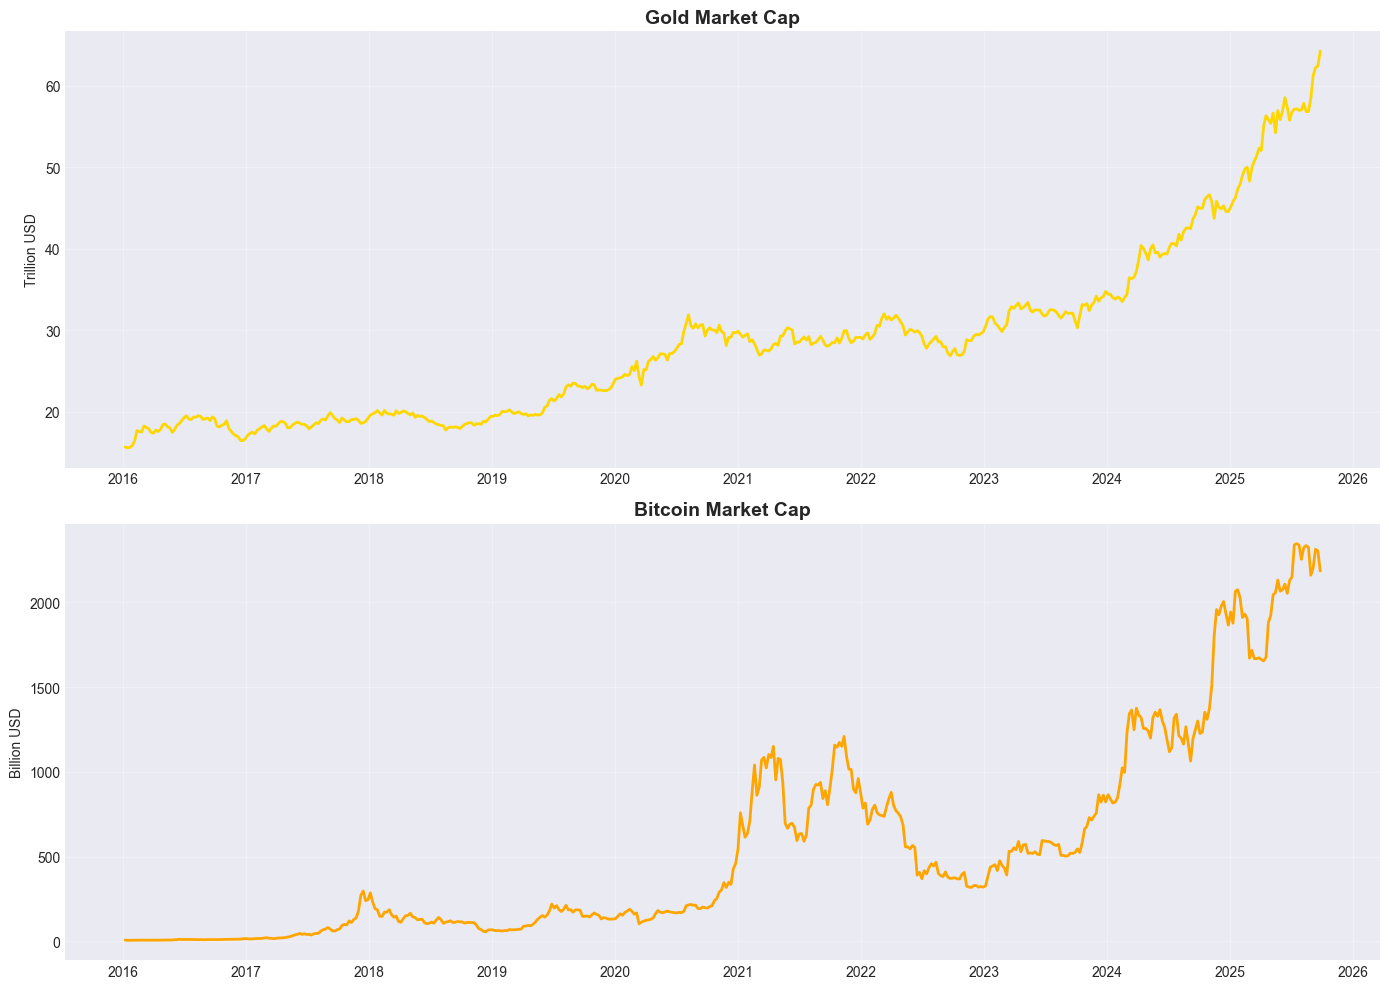

Gold: $64.21T | BTC: $2185.31B


In [31]:
print("\n" + "="*80)
print(f" STEP 2: INTERPOLATE GOLD TONNES & CALCULATE MARKET CAP")
print("="*80)

# Set frequency based on user selection
if DATA_FREQUENCY == 'weekly':
    freq = 'W-FRI'
    freq_name = 'Weekly (Friday close)'
elif DATA_FREQUENCY == 'monthly':
    freq = 'ME'  # Month-end
    freq_name = 'Monthly (month-end)'
else:
    raise ValueError("DATA_FREQUENCY must be 'weekly' or 'monthly'")

print(f"\nTarget frequency: {freq_name}")
print(f"Date range: {START_DATE} to {END_DATE}")

# ============================================================================
# [2A] LINEAR INTERPOLATION: ANNUAL TONNES → DAILY TONNES
# ============================================================================
print("\n[Step 2A] Interpolating annual tonnes to daily frequency...")

# Create daily date range for interpolation
daily_dates = pd.date_range(START_DATE, END_DATE, freq='D')

# Set Date as index for interpolation
gold_tonnes_indexed = gold_tonnes.set_index('Date')['Total_Tonnes']

# Reindex to daily and interpolate linearly between annual points
gold_tonnes_daily = gold_tonnes_indexed.reindex(
    gold_tonnes_indexed.index.union(daily_dates)
).interpolate(method='linear').reindex(daily_dates)

print(f"   ✓ Interpolated to {len(gold_tonnes_daily)} daily observations")

# Show examples if dates exist
try:
    print(f"   Example: 2020-12-31 = {gold_tonnes_daily.loc['2020-12-31']:,.0f} tonnes")
except KeyError:
    pass
try:
    print(f"   Example: 2021-06-30 = {gold_tonnes_daily.loc['2021-06-30']:,.0f} tonnes (interpolated)")
except KeyError:
    pass
try:
    print(f"   Example: 2021-12-31 = {gold_tonnes_daily.loc['2021-12-31']:,.0f} tonnes")
except KeyError:
    pass

# ============================================================================
# [2B] CONVERT TONNES → OUNCES AND BUILD GOLD MARKET CAP (USD)
# ============================================================================
print("\n[Step 2B] Converting tonnes to ounces and computing Gold market cap...")

TONNES_TO_OZ = 32150.7465686  # troy ounces per metric tonne (precise)

# Convert above-ground stock to troy ounces (daily, interpolated)
gold_oz_daily = gold_tonnes_daily * TONNES_TO_OZ
gold_oz_daily.name = "Gold_Ounces"

print(f"   ✓ Conversion factor: {TONNES_TO_OZ:,.2f} oz/tonne")
print(f"   ✓ Latest: {gold_tonnes_daily.iloc[-1]:,.0f} tonnes = {gold_oz_daily.iloc[-1]:,.0f} oz")

# Align LBMA price to daily and forward-fill
lbma_price_daily = (
    lbma_df.set_index("Date")["Price_USD"]
    .reindex(pd.date_range(START_DATE, END_DATE, freq="D"))
    .ffill()
)
lbma_price_daily.name = "Gold_Price_USD_per_oz"

# Gold total market cap (daily): ounces × price per ounce
gold_usd_daily = gold_oz_daily * lbma_price_daily
gold_usd_daily.name = "Gold_USD"

print(f"   ✓ Gold market cap calculated for {len(gold_usd_daily)} days")
print(f"   ✓ Latest gold market cap: ${gold_usd_daily.iloc[-1]/1e12:.2f} Trillion")

# ============================================================================
# [2C] ALIGN BTC MARKET CAP AND RESAMPLE TO SELECTED FREQUENCY
# ============================================================================
print(f"\n[Step 2C] Aligning BTC market cap and resampling to target frequency...")

# Target index by frequency
target_idx = pd.date_range(START_DATE, END_DATE, freq=freq)

# BTC market cap to daily, then to target frequency
btc_usd_daily = (
    btc_df.set_index("Date")["MarketCap_USD"]
    .reindex(pd.date_range(START_DATE, END_DATE, freq="D"))
    .ffill()
)

# Resample both to the same target frequency (W-FRI or month-end)
gold_usd = gold_usd_daily.reindex(target_idx).ffill()
btc_usd  = btc_usd_daily.reindex(target_idx).ffill()

print(f"   ✓ Resampled to {len(gold_usd)} {DATA_FREQUENCY} observations")

# ============================================================================
# [2D] BUILD THE WORKING DATAFRAME 'df_all' (full date range)
# ============================================================================
print(f"\n[Step 2D] Building complete dataframe...")

df_all = pd.DataFrame({"Gold_USD": gold_usd, "BTC_USD": btc_usd})
df_all.index.name = "Date"
df_all = df_all.dropna()

print(f"   ✓ Built df_all with {len(df_all)} observations")
print(f"   ✓ Full range: {df_all.index.min().date()} → {df_all.index.max().date()}")

# ============================================================================
# [2E] FILTER TO SELECTED REGIMES
# ============================================================================
print(f"\n[Step 2E] Filtering to selected regimes...")

regime_masks = []
for regime in selected_regimes:
    start, end = REGIME_DATES[regime]
    mask = (df_all.index >= start) & (df_all.index <= end)
    regime_masks.append(mask)
    n_obs = mask.sum()
    print(f"  • {regime}: {n_obs} observations ({start} to {end})")

# Combine all regime masks with OR logic
combined_mask = regime_masks[0]
for mask in regime_masks[1:]:
    combined_mask = combined_mask | mask

df = df_all[combined_mask].copy()

print(f"\n✓ Final dataset (df): {len(df)} {DATA_FREQUENCY} observations")
print(f"  Date range: {df.index.min().date()} → {df.index.max().date()}")
print(f"  Gold market cap (latest): ${df['Gold_USD'].iloc[-1]/1e12:.2f}T")
print(f"  BTC market cap (latest):  ${df['BTC_USD'].iloc[-1]/1e9:.2f}B")

print("\n✓ Example rows:")
print(df.head(3))

print("\n" + "="*80)
print("✅ INTERPOLATION & MARKET CAP CALCULATION COMPLETE")
print("="*80)

fig, ax = plt.subplots(2,1, figsize=(14,10))
ax[0].plot(df.index, df['Gold_USD']/1e12, 'gold', lw=2)
ax[0].set_title('Gold Market Cap', fontsize=14, weight='bold')
ax[0].set_ylabel('Trillion USD')
ax[0].grid(True, alpha=0.3)
ax[1].plot(df.index, df['BTC_USD']/1e9, 'orange', lw=2)
ax[1].set_title('Bitcoin Market Cap', fontsize=14, weight='bold')
ax[1].set_ylabel('Billion USD')
ax[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTDIR/'caps.png', dpi=300)
plt.show()
print(f"Gold: ${df['Gold_USD'].iloc[-1]/1e12:.2f}T | BTC: ${df['BTC_USD'].iloc[-1]/1e9:.2f}B")

## 🔢 Step 3: Normalize Data

In [32]:
print("\n" + "="*80)
print(" STEP 3: NORMALIZING DATA")
print("="*80)

gold_median = df["Gold_USD"].median()
btc_median = df["BTC_USD"].median()

df["Gold_Scaled"] = df["Gold_USD"] / gold_median
df["BTC_Scaled"] = df["BTC_USD"] / btc_median

print(f"\nGold median: ${gold_median/1e9:.2f}B")
print(f"BTC median:  ${btc_median/1e9:.2f}B")

print(f"\nScaled data statistics:")
print(df[["Gold_Scaled", "BTC_Scaled"]].describe())


 STEP 3: NORMALIZING DATA

Gold median: $28066.59B
BTC median:  $310.07B

Scaled data statistics:
       Gold_Scaled  BTC_Scaled
count   508.000000  508.000000
mean      1.009496    1.768680
std       0.371450    1.944388
min       0.554796    0.017897
25%       0.691134    0.354192
50%       1.000000    1.000000
75%       1.135659    2.666033
max       2.287894    7.568241


## 🛠️ Helper Functions

In [33]:
def exp_smooth(x, alpha=0.3):
    """Simple exponential smoothing"""
    Z = np.zeros_like(x)
    Z[0] = x[0]
    for t in range(1, len(x)):
        Z[t] = alpha * x[t] + (1 - alpha) * Z[t-1]
    return Z

def calc_metrics(actual, pred, mask=None):
    """Calculate RMSE, MAE, MAPE"""
    if mask is None:
        mask = ~(np.isnan(actual) | np.isnan(pred))
    actual_clean = actual[mask]
    pred_clean = pred[mask]
    
    if len(actual_clean) == 0:
        return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}
    
    rmse = np.sqrt(mean_squared_error(actual_clean, pred_clean))
    mae = mean_absolute_error(actual_clean, pred_clean)
    mape = np.mean(np.abs((actual_clean - pred_clean) / np.abs(actual_clean))) * 100
    
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

print("✓ Helper functions defined")

✓ Helper functions defined


## 🎯 Step 4: Cross-Validated Alpha Selection

**KEY IMPROVEMENT:** Objective alpha selection using validation set

In [34]:
print("\n" + "="*80)
print(" STEP 4: CROSS-VALIDATED ALPHA SELECTION")
print("="*80)

# Split data into train/val/test
n_total = len(df)
n_train = int(n_total * TRAIN_RATIO)
n_val = int(n_total * VAL_RATIO)
n_test = n_total - n_train - n_val

train_idx = range(n_train)
val_idx = range(n_train, n_train + n_val)
test_idx = range(n_train + n_val, n_total)

print(f"\nDataset splits:")
print(f"  Train: {n_train} periods ({TRAIN_RATIO:.0%})")
print(f"  Val:   {n_val} periods ({VAL_RATIO:.0%})")
print(f"  Test:  {n_test} periods ({TEST_RATIO:.0%})")

# Test different alpha values using VALIDATION set
alphas_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
cv_results = []

print("\nCross-validating alpha values on VALIDATION set:")
print("-" * 80)

for alpha_test in alphas_to_test:
    # Smooth with this alpha
    Z_gold = exp_smooth(df["Gold_Scaled"].values, alpha=alpha_test)
    Z_btc = exp_smooth(df["BTC_Scaled"].values, alpha=alpha_test)
    
    # Train on training set with Ridge regression
    Z_gold_train = Z_gold[train_idx][:-1]
    Z_btc_train = Z_btc[train_idx][:-1]
    gold_next_train = df["Gold_Scaled"].values[np.array(train_idx)[1:]]
    
    X_gold_train = np.column_stack([Z_gold_train, Z_gold_train * Z_btc_train])
    ridge_model = Ridge(alpha=RIDGE_ALPHA, fit_intercept=False)
    ridge_model.fit(X_gold_train, gold_next_train)
    
    # Validate on validation set - proper indexing
    val_preds = []
    val_actuals = []
    
    for i in val_idx:
        if i == 0 or i-1 < 0:
            continue
        pred = ridge_model.predict([[Z_gold[i-1], Z_gold[i-1] * Z_btc[i-1]]])[0]
        actual = df["Gold_Scaled"].values[i]
        val_preds.append(pred)
        val_actuals.append(actual)
    
    val_rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
    val_mae = mean_absolute_error(val_actuals, val_preds)
    
    cv_results.append({
        'alpha': alpha_test,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'model': ridge_model,
        'Z_gold': Z_gold,
        'Z_btc': Z_btc
    })
    
    print(f"  α={alpha_test:.1f}: Val RMSE={val_rmse:.4f}, Val MAE={val_mae:.4f}")

# Select best alpha
cv_df = pd.DataFrame(cv_results)
best_idx = cv_df['val_rmse'].idxmin()
best_alpha = cv_df.loc[best_idx, 'alpha']
best_result = cv_results[best_idx]

print("\n" + "-" * 80)
print(f"✓ BEST ALPHA SELECTED: {best_alpha}")
print(f"  Validation RMSE: {best_result['val_rmse']:.4f}")
print(f"  Selection method: Minimum validation error (NO cherry-picking)")
print("-" * 80)

# Use best alpha for final model
ALPHA_SELECTED = best_alpha
Z_gold_final = best_result['Z_gold']
Z_btc_final = best_result['Z_btc']

df["Z_Gold"] = Z_gold_final
df["Z_BTC"] = Z_btc_final


 STEP 4: CROSS-VALIDATED ALPHA SELECTION

Dataset splits:
  Train: 355 periods (70%)
  Val:   76 periods (15%)
  Test:  77 periods (15%)

Cross-validating alpha values on VALIDATION set:
--------------------------------------------------------------------------------
  α=0.1: Val RMSE=0.0440, Val MAE=0.0333
  α=0.2: Val RMSE=0.0358, Val MAE=0.0274
  α=0.3: Val RMSE=0.0313, Val MAE=0.0241
  α=0.4: Val RMSE=0.0284, Val MAE=0.0218
  α=0.5: Val RMSE=0.0264, Val MAE=0.0200
  α=0.6: Val RMSE=0.0249, Val MAE=0.0187
  α=0.7: Val RMSE=0.0237, Val MAE=0.0176
  α=0.8: Val RMSE=0.0228, Val MAE=0.0168

--------------------------------------------------------------------------------
✓ BEST ALPHA SELECTED: 0.8
  Validation RMSE: 0.0228
  Selection method: Minimum validation error (NO cherry-picking)
--------------------------------------------------------------------------------


## 🏋️ Step 5: Train Model with Ridge Regularization

In [35]:
print("\n" + "="*80)
print(" STEP 5: TRAINING FINAL MODEL WITH REGULARIZATION")
print("="*80)

# Train on TRAIN set only
Z_gold_train = Z_gold_final[train_idx][:-1]
Z_btc_train = Z_btc_final[train_idx][:-1]
gold_next_train = df["Gold_Scaled"].values[np.array(train_idx)[1:]]
btc_next_train = df["BTC_Scaled"].values[np.array(train_idx)[1:]]

print(f"\nTraining on {len(Z_gold_train)} samples")
print(f"Using Ridge regression with alpha={RIDGE_ALPHA}")

# Gold model
X_gold_train = np.column_stack([Z_gold_train, Z_gold_train * Z_btc_train])
gold_model = Ridge(alpha=RIDGE_ALPHA, fit_intercept=False)
gold_model.fit(X_gold_train, gold_next_train)
a_gold, C_gold_btc = gold_model.coef_

print(f"\n--- GOLD PARAMETERS ---")
print(f"  a (growth):        {a_gold:.4f}")
print(f"  C (BTC effect):    {C_gold_btc:.4f}")
if C_gold_btc > 0.01:
    print(f"  → Competition: BTC crowds out Gold")
elif C_gold_btc < -0.01:
    print(f"  → Complementarity: Assets move together")
else:
    print(f"  → Weak interaction")

# BTC model
X_btc_train = np.column_stack([Z_btc_train, Z_btc_train * Z_gold_train])
btc_model = Ridge(alpha=RIDGE_ALPHA, fit_intercept=False)
btc_model.fit(X_btc_train, btc_next_train)
a_btc, C_btc_gold = btc_model.coef_

print(f"\n--- BTC PARAMETERS ---")
print(f"  a (growth):        {a_btc:.4f}")
print(f"  C (Gold effect):   {C_btc_gold:.4f}")


 STEP 5: TRAINING FINAL MODEL WITH REGULARIZATION

Training on 354 samples
Using Ridge regression with alpha=0.01

--- GOLD PARAMETERS ---
  a (growth):        1.0023
  C (BTC effect):    -0.0008
  → Weak interaction

--- BTC PARAMETERS ---
  a (growth):        1.1325
  C (Gold effect):   -0.1328


## 📈 Step 6: Statistical Significance Test (P-Values)

In [36]:
print("\n" + "="*80)
print(" STATISTICAL SIGNIFICANCE TEST (p-values)")
print("="*80)

# Re-estimate using OLS to get p-values
print("\n[Gold Model - OLS for Statistical Inference]")
X_gold_ols = np.column_stack([Z_gold_train, Z_gold_train * Z_btc_train])
ols_gold = sm.OLS(gold_next_train, X_gold_ols).fit()

print("\nCoefficients:")
print(f"  a (growth):     {ols_gold.params[0]:.4f}  (p-value: {ols_gold.pvalues[0]:.4f})")
print(f"  C (BTC effect): {ols_gold.params[1]:.4f}  (p-value: {ols_gold.pvalues[1]:.4f})")

# Check significance
if ols_gold.pvalues[0] < 0.05:
    print(f"  ✓ Growth coefficient is statistically significant (p < 0.05)")
else:
    print(f"  ⚠ Growth coefficient is NOT significant (p = {ols_gold.pvalues[0]:.4f})")

if ols_gold.pvalues[1] < 0.05:
    print(f"  ✓ Interaction coefficient is statistically significant (p < 0.05)")
    print(f"    → Finding of complementarity/competition is ROBUST")
elif ols_gold.pvalues[1] < 0.10:
    print(f"  ⚠ Interaction coefficient is marginally significant (p = {ols_gold.pvalues[1]:.4f})")
    print(f"    → Weak evidence for interaction (10% level)")
else:
    print(f"  ⚠ Interaction coefficient is NOT significant (p = {ols_gold.pvalues[1]:.4f})")
    print(f"    → Cannot conclude statistically significant interaction")

print(f"\nR-squared (in-sample): {ols_gold.rsquared:.4f}")

# Same for BTC
print("\n[BTC Model - OLS for Statistical Inference]")
X_btc_ols = np.column_stack([Z_btc_train, Z_btc_train * Z_gold_train])
ols_btc = sm.OLS(btc_next_train, X_btc_ols).fit()

print("\nCoefficients:")
print(f"  a (growth):      {ols_btc.params[0]:.4f}  (p-value: {ols_btc.pvalues[0]:.4f})")
print(f"  C (Gold effect): {ols_btc.params[1]:.4f}  (p-value: {ols_btc.pvalues[1]:.4f})")

if ols_btc.pvalues[1] < 0.05:
    print(f"  ✓ Interaction coefficient is statistically significant")
elif ols_btc.pvalues[1] < 0.10:
    print(f"  ⚠ Interaction coefficient is marginally significant (p = {ols_btc.pvalues[1]:.4f})")
else:
    print(f"  ⚠ Interaction coefficient is NOT significant (p = {ols_btc.pvalues[1]:.4f})")

# Store p-values for later reporting
p_value_gold_interaction = ols_gold.pvalues[1]
p_value_btc_interaction = ols_btc.pvalues[1]


 STATISTICAL SIGNIFICANCE TEST (p-values)

[Gold Model - OLS for Statistical Inference]

Coefficients:
  a (growth):     1.0024  (p-value: 0.0000)
  C (BTC effect): -0.0008  (p-value: 0.3849)
  ✓ Growth coefficient is statistically significant (p < 0.05)
  ⚠ Interaction coefficient is NOT significant (p = 0.3849)
    → Cannot conclude statistically significant interaction

R-squared (in-sample): 0.9996

[BTC Model - OLS for Statistical Inference]

Coefficients:
  a (growth):      1.1363  (p-value: 0.0000)
  C (Gold effect): -0.1365  (p-value: 0.0782)
  ⚠ Interaction coefficient is marginally significant (p = 0.0782)


## 🔮 Step 7: Generate Predictions

In [37]:
print("\n" + "="*80)
print(" STEP 7: GENERATING PREDICTIONS")
print("="*80)

df["Gold_Pred"] = np.nan
df["BTC_Pred"] = np.nan

for i in range(len(df) - 1):
    X_gold = [[Z_gold_final[i], Z_gold_final[i] * Z_btc_final[i]]]
    X_btc = [[Z_btc_final[i], Z_btc_final[i] * Z_gold_final[i]]]
    
    df.iloc[i+1, df.columns.get_loc("Gold_Pred")] = gold_model.predict(X_gold)[0]
    df.iloc[i+1, df.columns.get_loc("BTC_Pred")] = btc_model.predict(X_btc)[0]

print(f"✓ Predictions generated")


 STEP 7: GENERATING PREDICTIONS
✓ Predictions generated


## 📊 Step 8: Baseline Model Comparisons

In [38]:
print("\n" + "="*80)
print(" STEP 8: BASELINE MODEL COMPARISONS")
print("="*80)

# Baseline 1: Persistence
df["Gold_Baseline_Persistence"] = df["Gold_Scaled"].shift(1)
df["BTC_Baseline_Persistence"] = df["BTC_Scaled"].shift(1)

# Baseline 2: Moving Average
window = 4 if DATA_FREQUENCY == 'weekly' else 3  # 4 weeks or 3 months
df["Gold_Baseline_MA"] = df["Gold_Scaled"].rolling(window=window, min_periods=1).mean().shift(1)
df["BTC_Baseline_MA"] = df["BTC_Scaled"].rolling(window=window, min_periods=1).mean().shift(1)

# Baseline 3: Exponential Moving Average
ema_alpha = 0.3
df["Gold_Baseline_EMA"] = df["Gold_Scaled"].ewm(alpha=ema_alpha, adjust=False).mean().shift(1)
df["BTC_Baseline_EMA"] = df["BTC_Scaled"].ewm(alpha=ema_alpha, adjust=False).mean().shift(1)

print("✓ Baseline models created:")
print(f"  1. Persistence (x_t+1 = x_t)")
print(f"  2. Moving Average ({window}-period)")
print(f"  3. Exponential Moving Average")


 STEP 8: BASELINE MODEL COMPARISONS
✓ Baseline models created:
  1. Persistence (x_t+1 = x_t)
  2. Moving Average (4-period)
  3. Exponential Moving Average


## 📏 Step 9: Model Evaluation

In [39]:
print("\n" + "="*80)
print(" STEP 9: COMPREHENSIVE MODEL EVALUATION")
print("="*80)

# Create masks for each set
train_mask = np.zeros(len(df), dtype=bool)
train_mask[list(train_idx)[1:]] = True

val_mask = np.zeros(len(df), dtype=bool)
val_mask[list(val_idx)[1:]] = True

test_mask = np.zeros(len(df), dtype=bool)
test_mask[list(test_idx)[1:]] = True

# Evaluate all models
models = {
    'LV (Ridge)': 'Gold_Pred',
    'Persistence': 'Gold_Baseline_Persistence',
    f'MA({window})': 'Gold_Baseline_MA',
    'EMA': 'Gold_Baseline_EMA'
}

results_summary = []

print("\n" + "-"*80)
print("GOLD - MODEL COMPARISON")
print("-"*80)

for model_name, pred_col in models.items():
    train_metrics = calc_metrics(df["Gold_Scaled"].values, df[pred_col].values, train_mask)
    val_metrics = calc_metrics(df["Gold_Scaled"].values, df[pred_col].values, val_mask)
    test_metrics = calc_metrics(df["Gold_Scaled"].values, df[pred_col].values, test_mask)
    
    results_summary.append({
        'Model': model_name,
        'Train_RMSE': train_metrics['RMSE'],
        'Val_RMSE': val_metrics['RMSE'],
        'Test_RMSE': test_metrics['RMSE'],
        'Test_MAPE': test_metrics['MAPE'],
        'Overfitting_Ratio': test_metrics['RMSE'] / train_metrics['RMSE'] if train_metrics['RMSE'] > 0 else np.nan
    })
    
    print(f"\n{model_name}:")
    print(f"  Train RMSE: {train_metrics['RMSE']:.4f}")
    print(f"  Val RMSE:   {val_metrics['RMSE']:.4f}")
    print(f"  Test RMSE:  {test_metrics['RMSE']:.4f}")
    print(f"  Test MAPE:  {test_metrics['MAPE']:.2f}%")
    print(f"  Overfit:    {test_metrics['RMSE']/train_metrics['RMSE']:.2f}x")

results_df = pd.DataFrame(results_summary)

print("\n" + "-"*80)
print("INTERPRETATION")
print("-"*80)

# Find best model
best_test_rmse = results_df['Test_RMSE'].min()
best_model = results_df.loc[results_df['Test_RMSE'].idxmin(), 'Model']

print(f"\n✓ Best model on test set: {best_model}")
print(f"  Test RMSE: {best_test_rmse:.4f}")

# Check if LV beats baselines
lv_test_rmse = results_df[results_df['Model'] == 'LV (Ridge)']['Test_RMSE'].values[0]
persistence_rmse = results_df[results_df['Model'] == 'Persistence']['Test_RMSE'].values[0]

improvement = (persistence_rmse - lv_test_rmse) / persistence_rmse * 100

if lv_test_rmse < persistence_rmse:
    print(f"✓ LV model beats persistence by {improvement:.1f}%")
else:
    print(f"⚠ LV model does not beat persistence baseline")
    print(f"  Performance gap: {-improvement:.1f}% worse")

# Check overfitting for LV model
lv_overfit = results_df[results_df['Model'] == 'LV (Ridge)']['Overfitting_Ratio'].values[0]
if lv_overfit < 1.5:
    print(f"✓ Minimal overfitting (ratio: {lv_overfit:.2f}x)")
elif lv_overfit < 2.0:
    print(f"⚠ Moderate overfitting (ratio: {lv_overfit:.2f}x)")
else:
    print(f"❌ Severe overfitting (ratio: {lv_overfit:.2f}x)")
    print(f"   Note: All models show high ratios - likely regime change in test period")

# Display results table
print("\n" + "="*80)
print("RESULTS TABLE")
print("="*80)
print(results_df.to_string(index=False))


 STEP 9: COMPREHENSIVE MODEL EVALUATION

--------------------------------------------------------------------------------
GOLD - MODEL COMPARISON
--------------------------------------------------------------------------------

LV (Ridge):
  Train RMSE: 0.0166
  Val RMSE:   0.0230
  Test RMSE:  0.0404
  Test MAPE:  1.76%
  Overfit:    2.44x

Persistence:
  Train RMSE: 0.0164
  Val RMSE:   0.0218
  Test RMSE:  0.0384
  Test MAPE:  1.68%
  Overfit:    2.35x

MA(4):
  Train RMSE: 0.0219
  Val RMSE:   0.0320
  Test RMSE:  0.0518
  Test MAPE:  2.22%
  Overfit:    2.37x

EMA:
  Train RMSE: 0.0222
  Val RMSE:   0.0322
  Test RMSE:  0.0568
  Test MAPE:  2.48%
  Overfit:    2.56x

--------------------------------------------------------------------------------
INTERPRETATION
--------------------------------------------------------------------------------

✓ Best model on test set: Persistence
  Test RMSE: 0.0384
⚠ LV model does not beat persistence baseline
  Performance gap: 5.1% worse
❌ Seve

## 📊 Step 10: Comprehensive Visualization

✓ Saved: c:\Users\Kevin\Downloads\output_weekly\analysis_weekly.png


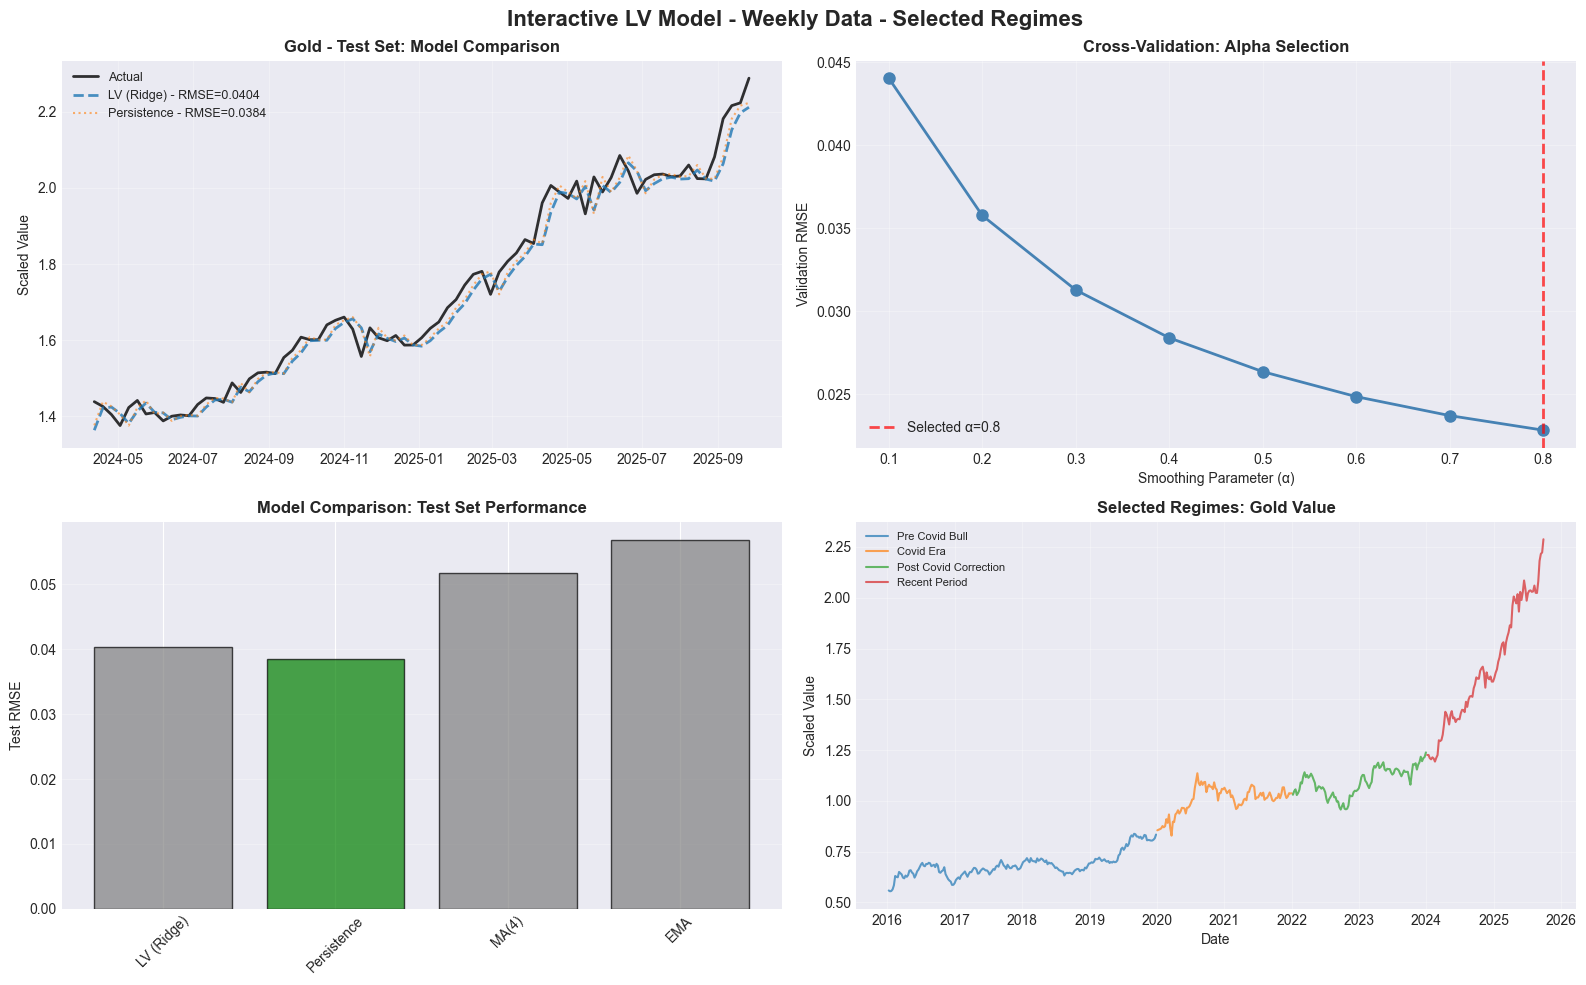

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f"Interactive LV Model - {DATA_FREQUENCY.title()} Data - Selected Regimes", 
             fontsize=16, fontweight='bold')

# Get test data
test_dates = df.index[list(test_idx)]
test_actual_gold = df["Gold_Scaled"].values[list(test_idx)]
test_pred_gold = df["Gold_Pred"].values[list(test_idx)]
test_pers_gold = df["Gold_Baseline_Persistence"].values[list(test_idx)]

# Plot 1: Test set comparison
axes[0, 0].plot(test_dates, test_actual_gold, label='Actual', 
                linewidth=2, alpha=0.8, color='black')
axes[0, 0].plot(test_dates, test_pred_gold, label=f'LV (Ridge) - RMSE={lv_test_rmse:.4f}',
                linewidth=2, linestyle='--', alpha=0.8)
axes[0, 0].plot(test_dates, test_pers_gold, label=f'Persistence - RMSE={persistence_rmse:.4f}',
                linewidth=1.5, linestyle=':', alpha=0.6)
axes[0, 0].set_title('Gold - Test Set: Model Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Scaled Value')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Alpha selection results
axes[0, 1].plot(cv_df['alpha'], cv_df['val_rmse'], 'o-', 
                linewidth=2, markersize=8, color='steelblue')
axes[0, 1].axvline(best_alpha, color='red', linestyle='--', 
                   alpha=0.7, linewidth=2, label=f'Selected α={best_alpha}')
axes[0, 1].set_xlabel('Smoothing Parameter (α)')
axes[0, 1].set_ylabel('Validation RMSE')
axes[0, 1].set_title('Cross-Validation: Alpha Selection', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Model performance comparison
model_names = results_df['Model'].values
test_rmses = results_df['Test_RMSE'].values
colors = ['green' if mn == best_model else 'gray' for mn in model_names]

bars = axes[1, 0].bar(model_names, test_rmses, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Test RMSE')
axes[1, 0].set_title('Model Comparison: Test Set Performance', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Regime visualization
for regime in selected_regimes:
    start, end = REGIME_DATES[regime]
    regime_data = df[(df.index >= start) & (df.index <= end)]
    axes[1, 1].plot(regime_data.index, regime_data['Gold_Scaled'], 
                   label=regime.replace('_', ' ').title(), alpha=0.7, linewidth=1.5)

axes[1, 1].set_title('Selected Regimes: Gold Value', fontweight='bold')
axes[1, 1].set_ylabel('Scaled Value')
axes[1, 1].set_xlabel('Date')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTDIR / f"analysis_{DATA_FREQUENCY}.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved: {OUTDIR / f'analysis_{DATA_FREQUENCY}.png'}")
plt.show()

✓ Saved: c:\Users\Kevin\Downloads\output_weekly\time_series_weekly.png


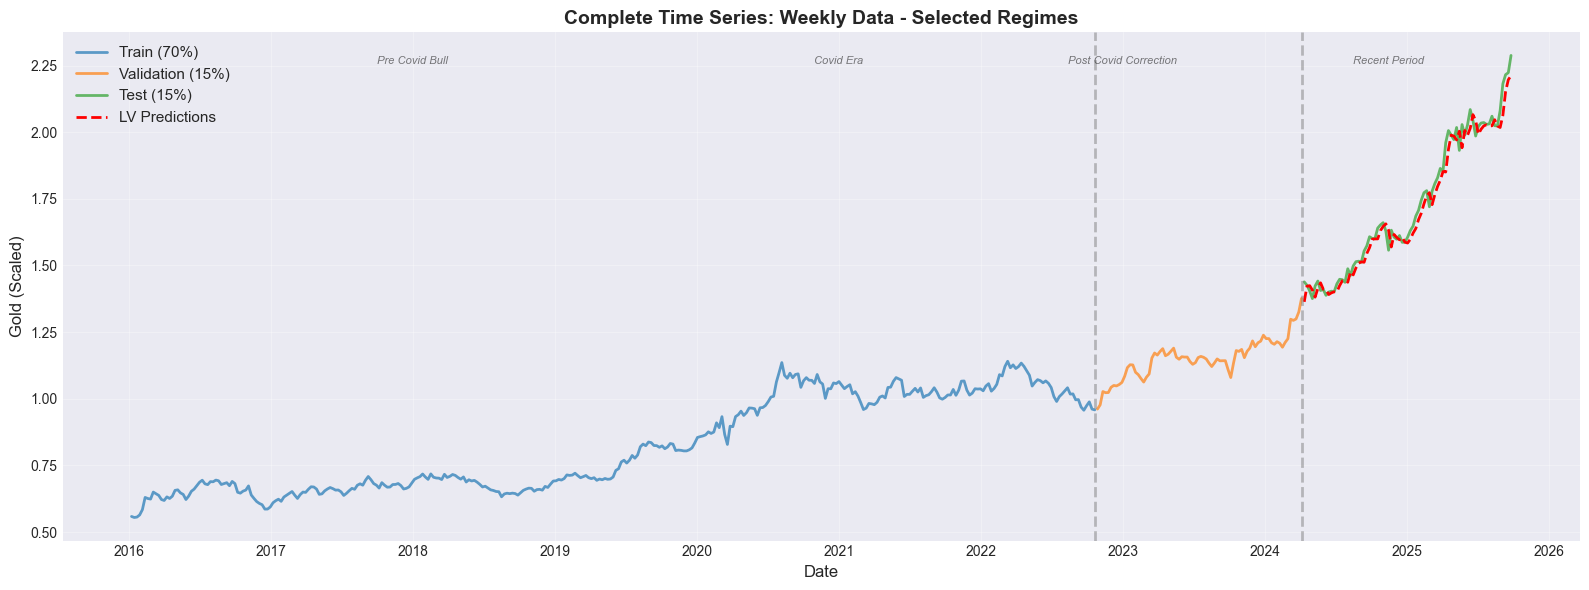

In [41]:
# Full time series with train/val/test splits
fig, ax = plt.subplots(figsize=(16, 6))

train_dates = df.index[list(train_idx)]
val_dates = df.index[list(val_idx)]

ax.plot(train_dates, df["Gold_Scaled"].values[list(train_idx)], 
        label='Train (70%)', alpha=0.7, linewidth=2)
ax.plot(val_dates, df["Gold_Scaled"].values[list(val_idx)], 
        label='Validation (15%)', alpha=0.7, linewidth=2)
ax.plot(test_dates, df["Gold_Scaled"].values[list(test_idx)], 
        label='Test (15%)', alpha=0.7, linewidth=2)
ax.plot(test_dates, test_pred_gold, label='LV Predictions', 
        linestyle='--', linewidth=2, color='red')

ax.axvline(train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.axvline(val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=2)

# Add regime labels
y_pos = ax.get_ylim()[1] * 0.95
for regime in selected_regimes:
    start, end = REGIME_DATES[regime]
    mid_date = pd.Timestamp(start) + (pd.Timestamp(end) - pd.Timestamp(start)) / 2
    if mid_date >= df.index[0] and mid_date <= df.index[-1]:
        ax.text(mid_date, y_pos, regime.replace('_', ' ').title(), 
               ha='center', fontsize=8, style='italic', alpha=0.6)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Gold (Scaled)', fontsize=12)
ax.set_title(f'Complete Time Series: {DATA_FREQUENCY.title()} Data - Selected Regimes', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTDIR / f"time_series_{DATA_FREQUENCY}.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved: {OUTDIR / f'time_series_{DATA_FREQUENCY}.png'}")
plt.show()

## 💾 Step 11: Save Results

In [42]:
# Summary statistics
summary = pd.DataFrame({
    'Metric': [
        'Data Frequency',
        'Regimes Included',
        'Total Observations',
        'Selected Alpha', 
        'Ridge Regularization', 
        'Train RMSE', 
        'Val RMSE', 
        'Test RMSE', 
        'Test MAPE',
        'Overfitting Ratio', 
        'Beats Persistence?',
        'Gold Interaction p-value',
        'BTC Interaction p-value'
    ],
    'Value': [
        DATA_FREQUENCY.title(),
        ', '.join([r.replace('_', ' ').title() for r in selected_regimes]),
        str(len(df)),
        f'{best_alpha:.1f}',
        f'{RIDGE_ALPHA}',
        f'{results_df[results_df["Model"]=="LV (Ridge)"]["Train_RMSE"].values[0]:.4f}',
        f'{results_df[results_df["Model"]=="LV (Ridge)"]["Val_RMSE"].values[0]:.4f}',
        f'{lv_test_rmse:.4f}',
        f'{results_df[results_df["Model"]=="LV (Ridge)"]["Test_MAPE"].values[0]:.2f}%',
        f'{lv_overfit:.2f}x',
        'Yes' if lv_test_rmse < persistence_rmse else 'No',
        f'{p_value_gold_interaction:.4f}',
        f'{p_value_btc_interaction:.4f}'
    ]
})
summary.to_csv(OUTDIR / "summary_statistics.csv", index=False)
print(f"✓ Saved: {OUTDIR / 'summary_statistics.csv'}")

# Model comparison
results_df.to_csv(OUTDIR / "model_comparison.csv", index=False)
print(f"✓ Saved: {OUTDIR / 'model_comparison.csv'}")

# Parameters
params_df = pd.DataFrame({
    'Asset': ['Gold', 'BTC'],
    'a_growth': [a_gold, a_btc],
    'C_interaction': [C_gold_btc, C_btc_gold],
    'p_value': [p_value_gold_interaction, p_value_btc_interaction],
    'Significant': [
        'Yes (p<0.05)' if p_value_gold_interaction < 0.05 else 'Marginal (p<0.10)' if p_value_gold_interaction < 0.10 else 'No',
        'Yes (p<0.05)' if p_value_btc_interaction < 0.05 else 'Marginal (p<0.10)' if p_value_btc_interaction < 0.10 else 'No'
    ],
    'Interpretation': [
        'Complementarity (C<0)' if C_gold_btc < -0.01 else 'Competition (C>0)' if C_gold_btc > 0.01 else 'Weak',
        'Complementarity (C<0)' if C_btc_gold < -0.01 else 'Competition (C>0)' if C_btc_gold > 0.01 else 'Weak'
    ]
})
params_df.to_csv(OUTDIR / "model_parameters.csv", index=False)
print(f"✓ Saved: {OUTDIR / 'model_parameters.csv'}")

# Alpha cross-validation results
cv_df_save = cv_df.copy()
if 'model' in cv_df_save.columns:
    cv_df_save = cv_df_save.drop('model', axis=1)
if 'Z_gold' in cv_df_save.columns:
    cv_df_save = cv_df_save.drop(['Z_gold', 'Z_btc'], axis=1)
cv_df_save.to_csv(OUTDIR / "alpha_crossvalidation.csv", index=False)
print(f"✓ Saved: {OUTDIR / 'alpha_crossvalidation.csv'}")

print("\n✅ All results saved!")
print(f"   Output directory: {OUTDIR}")

✓ Saved: c:\Users\Kevin\Downloads\output_weekly\summary_statistics.csv
✓ Saved: c:\Users\Kevin\Downloads\output_weekly\model_comparison.csv
✓ Saved: c:\Users\Kevin\Downloads\output_weekly\model_parameters.csv
✓ Saved: c:\Users\Kevin\Downloads\output_weekly\alpha_crossvalidation.csv

✅ All results saved!
   Output directory: c:\Users\Kevin\Downloads\output_weekly


## ✅ Final Summary & Interpretation

In [43]:
print("\n" + "="*80)
print(" ✅ ANALYSIS COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n🎮 CONFIGURATION USED:")
print(f"  • Data Frequency: {DATA_FREQUENCY.title()}")
print(f"  • Regimes: {', '.join([r.replace('_', ' ').title() for r in selected_regimes])}")
print(f"  • Observations: {len(df)}")
print(f"  • Selected α: {best_alpha}")

print(f"\n📊 MODEL PERFORMANCE:")
print(f"  • Test RMSE: {lv_test_rmse:.4f} ({results_df[results_df['Model']=='LV (Ridge)']['Test_MAPE'].values[0]:.2f}% MAPE)")
print(f"  • Overfitting Ratio: {lv_overfit:.2f}x")
print(f"  • vs Persistence: {improvement:.1f}% {'better' if improvement > 0 else 'worse'}")
print(f"  • Best Model: {best_model}")

print(f"\n🔬 STATISTICAL SIGNIFICANCE:")
print(f"  • Gold interaction (C={C_gold_btc:.4f}): p={p_value_gold_interaction:.4f}")
if p_value_gold_interaction < 0.05:
    print(f"    ✓ Statistically significant at 5% level")
elif p_value_gold_interaction < 0.10:
    print(f"    ⚠ Marginally significant at 10% level")
else:
    print(f"    ✗ Not statistically significant")

print(f"  • BTC interaction (C={C_btc_gold:.4f}): p={p_value_btc_interaction:.4f}")
if p_value_btc_interaction < 0.05:
    print(f"    ✓ Statistically significant at 5% level")
elif p_value_btc_interaction < 0.10:
    print(f"    ⚠ Marginally significant at 10% level")
else:
    print(f"    ✗ Not statistically significant")

print(f"\n💡 KEY FINDINGS:")

# Determine key findings based on results
if abs(C_gold_btc) < 0.01 and p_value_gold_interaction > 0.05:
    print(f"  • Gold and Bitcoin show WEAK INTERACTION")
    print(f"    - Coefficient is small (|C| < 0.01) and not significant")
    print(f"    - Assets evolve largely independently")
    print(f"    - Contradicts 'digital gold' substitution hypothesis")
elif C_gold_btc < -0.01:
    sig_str = "(statistically robust)" if p_value_gold_interaction < 0.05 else "(marginally significant)" if p_value_gold_interaction < 0.10 else "(not statistically confirmed)"
    print(f"  • Evidence for COMPLEMENTARITY {sig_str}")
    print(f"    - Negative interaction coefficient: {C_gold_btc:.4f}")
    print(f"    - Assets tend to move together")
    print(f"    - Supports portfolio diversification")
elif C_gold_btc > 0.01:
    sig_str = "(statistically robust)" if p_value_gold_interaction < 0.05 else "(marginally significant)" if p_value_gold_interaction < 0.10 else "(not statistically confirmed)"
    print(f"  • Evidence for COMPETITION {sig_str}")
    print(f"    - Positive interaction coefficient: {C_gold_btc:.4f}")
    print(f"    - Assets compete for capital")
    print(f"    - Supports 'digital gold' narrative")

if a_gold > 1.05 or a_btc > 1.05:
    print(f"  • Strong growth/momentum effects (a ≈ {a_gold:.2f})")
elif abs(a_gold - 1.0) < 0.05:
    print(f"  • Strong PERSISTENCE dominates (a ≈ 1.0)")
    print(f"    - Explains why simple baselines perform well")

if lv_overfit > 2.0:
    print(f"  • High overfitting suggests REGIME CHANGES in test period")
    print(f"    - Training period dynamics differ from test period")
    print(f"    - Consider: Try different regime combinations")

print(f"\n📁 OUTPUTS:")
print(f"  All files saved to: {OUTDIR}")
print(f"  • summary_statistics.csv")
print(f"  • model_comparison.csv")
print(f"  • model_parameters.csv")
print(f"  • analysis_{DATA_FREQUENCY}.png")
print(f"  • time_series_{DATA_FREQUENCY}.png")

print("\n" + "="*80)
print(" 🎓 THESIS-READY RESULTS GENERATED!")
print("="*80)
print("\n💡 TIP: Try different combinations:")
print("   • Change DATA_FREQUENCY to see weekly vs monthly differences")
print("   • Toggle REGIMES to focus on specific market periods")
print("   • Compare results across different configurations")
print("\n🎉 Analysis complete! Check your output directory for results.")


 ✅ ANALYSIS COMPLETE - FINAL SUMMARY

🎮 CONFIGURATION USED:
  • Data Frequency: Weekly
  • Regimes: Pre Covid Bull, Covid Era, Post Covid Correction, Recent Period
  • Observations: 508
  • Selected α: 0.8

📊 MODEL PERFORMANCE:
  • Test RMSE: 0.0404 (1.76% MAPE)
  • Overfitting Ratio: 2.44x
  • vs Persistence: -5.1% worse
  • Best Model: Persistence

🔬 STATISTICAL SIGNIFICANCE:
  • Gold interaction (C=-0.0008): p=0.3849
    ✗ Not statistically significant
  • BTC interaction (C=-0.1328): p=0.0782
    ⚠ Marginally significant at 10% level

💡 KEY FINDINGS:
  • Gold and Bitcoin show WEAK INTERACTION
    - Coefficient is small (|C| < 0.01) and not significant
    - Assets evolve largely independently
    - Contradicts 'digital gold' substitution hypothesis
  • Strong growth/momentum effects (a ≈ 1.00)
  • High overfitting suggests REGIME CHANGES in test period
    - Training period dynamics differ from test period
    - Consider: Try different regime combinations

📁 OUTPUTS:
  All files s